In [1]:
import numpy as np
from numpy import linalg
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import cvxopt
import cvxopt.solvers
def linear_kernel(x1, x2):
    return np.dot(x1, x2)
def polynomial_kernel(x, y, gamma = 1, r = 1, d=3):
    return (r + gamma*np.dot(x, y)) ** d
def gaussian_kernel(x, y, sigma=5.0):
# gamma = 1.0/(2 * (sigma ** 2))
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [2]:
class SVM(object):
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Solve Quadratic Programming problem
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
                
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        # Lagrange multipliers a = \lambda
        a = np.ravel(solution['x'])
        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))
        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)
            # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
    def predict(self, X):
        return np.sign(self.project(X))
    
if __name__ == "__main__":
    import pylab as pl
    def gen_lin_separable_data():
    # generate training data in the 2-d case
        return X1, y1, X2, y2
    def gen_non_lin_separable_data():

        return X1, y1, X2, y2
    def gen_lin_separable_overlap_data():
        return X1, y1, X2, y2
    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train
    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test
    # def plot_margin(X1_train, X2_train, clf):
    # def test_linear():
    # def test_non_linear():
    # def test_soft():
    #test_linear()
    #test_non_linear()

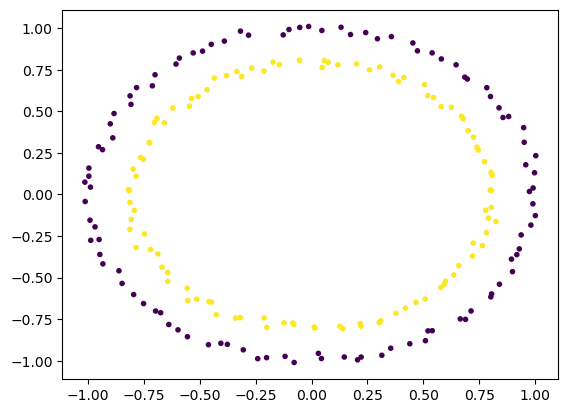

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
# Generate dataset and targets
X, Y = make_circles(n_samples = 200, noise = 0.02)
# visualizing data
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.')
plt.show()

Accuracy score  linear 0.505
Accuracy score  sigmoid 0.49
Accuracy score  poly 1.0
Accuracy score  rbf 1.0


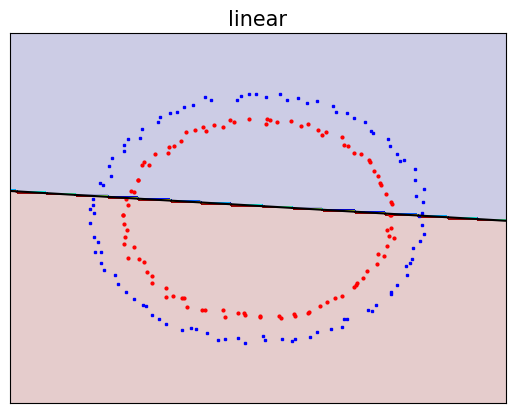

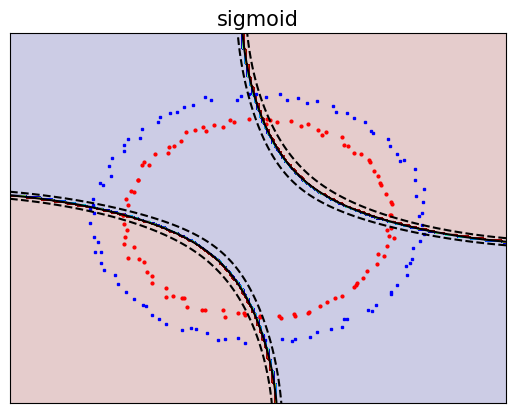

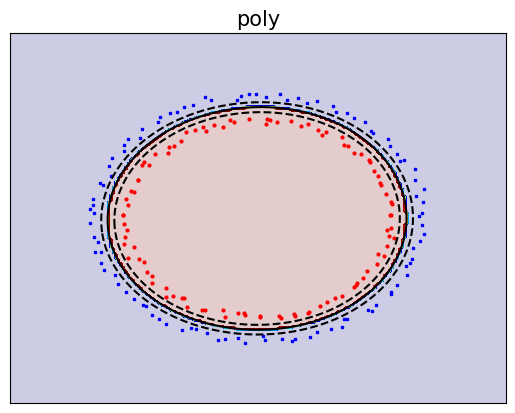

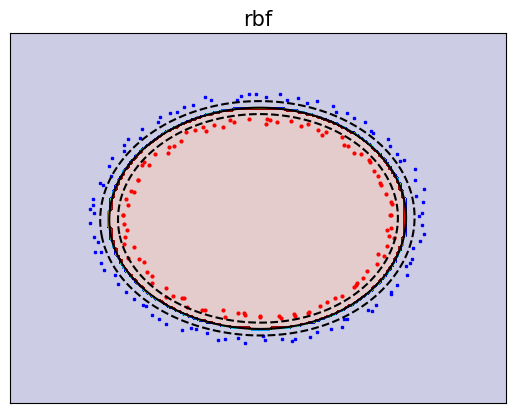

In [7]:
fignum = 1
# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X, Y)
    y_pred = clf.predict(X)
    with PdfPages(kernel + '3.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,facecolors='None')
        plt.plot(X[Y==0, 0], X[Y==0, 1], 'bs', markersize = 2)
        plt.plot(X[Y==1, 0], X[Y==1, 1], 'ro', markersize = 2)
        plt.axis('tight')
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
        levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        pdf.savefig()
        print("Accuracy score ", kernel, accuracy_score(Y, y_pred))
plt.show()